# Training Neural Networks

Neural Network를 정의하고 훈련하여 MNIST 데이터 셋으로부터 손글씨 숫자를 인식하도록 하자.

![img](../assets/function_approx.png)

훈련 데이터로 신경망의 parameter (=weights,bias)를 우리가 원하는 답에 가깝게 근사하도록 해야 한다.

이러한 parameters를 찾기 위해서,**loss function** (=cost)를 사용한다. 회귀문제에서 loss 함수는 mean squared loss를 사용하고 분류 문제를 위해서는 cross entropy를 주로 활용한다.

신경망의 학습 목표는 이러한 loss를 최소화하는 parameter를 찾는 것에 있다. 이러한 과정은  **gradient descent**알고리즘을 활용한다. gradient 는 어떤 한점에서 loss function의 기울기를 말하고 이것은 해당 loss를 가장 빠르게 감소할수 있는 방향과 크기를 나타낸다. loss를 최소화하는 방향으로 진행하는 학습은 높은 산을 내려가는 방법과 비교할 수 있다.

![img](../assets/gradient_descent.png)

## Backpropagation

깊이가 깊은 multilayer neural network에서는 gradient를 계산하기 쉽지 않다. multilayer networks를 훈련하기 위한 다양한 연구가 진행되어 왔다.

multilayer networks를 훈련하기 위한 방법이 **backpropagation** 이다. 궁극적으로 backpropagation은 합성함수 미분에서 chain rule를 구현하는 것이다. 이해하기 쉽도록 2 layer network의 computational graph로 표현하면 다음과 같다.
![img](../assets/backprop_diagram.png)

weights를 학습하기 위해 gradient descent를 사용한다. backpropagation은 loss를 backwards로 전파한다.

$$
\large \frac{\partial \ell}{\partial W_1} = \frac{\partial L_1}{\partial W_1} \frac{\partial S}{\partial L_1} \frac{\partial L_2}{\partial S} \frac{\partial \ell}{\partial L_2}
$$

weights의 update 는 다음과 같이 수행된다. 이 때 $\alpha$는 learning rate이다.  

$$
\large W^\prime_1 = W_1 - \alpha \frac{\partial \ell}{\partial W_1}
$$

learning rate $\alpha$ 는 weight update steps으로 update 속도와 관련되어 있다.

## Losses in PyTorch

`nn` module은 cross-entropy loss (`nn.CrossEntropyLoss`)와 같은 loss함수를 제공한다. 보통 `criterion`이라는 이름으로 할당한다. MNIST와 같은 분류 문제에서 출력층의 활성화 함수는 softmax function를 사용하여 각 class별 확률을 출력한다. loss함수로는 cross-entropy를 사용한다. 

이때 주의해야 할 점이 있다. [the documentation for `nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss),

> `nn.LogSoftmax()` 와 `nn.NLLLoss()` 를 하나로 결합한 것이 cross-entropy이다.
>
> 신경망의 최종 출력은 각 class에 해당하는 score이다.

즉, 신경망의 최종 출력은 softmax 활성화 함수 없이 그대로 score만을 출력하고, cross-entropy를 loss함수로 적용하면 된다.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5, )),
                              ])
# Download and load the training data
trainset = datasets.MNIST('../data', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

C:\Users\aoneko\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [2]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))

# Define the loss
criterion = nn.CrossEntropyLoss()

# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.2935, grad_fn=<NllLossBackward>)


출력층의 활성화 함수로 log-softmax `nn.LogSoftmax` 또는 `F.log_softmax` ([documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.LogSoftmax))를 적용하는 형태로 구성 가능하다. 그렇게 되면 출력되는 output에 exponential `torch.exp(output)`을 적용하여 class의 확률을 구할 수 있다. log-softmax output에 negative log likelihood loss, `nn.NLLLoss` ([documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.NLLLoss))를 loss함수로 적용한다.

>**실습 :** log-softmax를 출력층의 활성화 함수로 지정하시오.  
loss 함수는 negative log likelihood loss로 지정하시오.

In [3]:
## Solution

# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

# Define the loss
criterion = nn.NLLLoss()

# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our log-probabilities
logps = model(images)
# Calculate the loss with the logps and the labels
loss = criterion(logps, labels)

print(loss)

tensor(2.3048, grad_fn=<NllLossBackward>)


## Autograd

Torch 는 `autograd` module을 제공한다. `autograd`는 자동으로 텐서의 gradients 를 계산한다. `autograd`를 사용하여 parameters의 gradient를 구한다.  텐서를 생성할 때 `requires_grad = True` 를 쓴다. 또는  `x.requires_grad_(True)`를 사용한다.

gradient의 자동 계산 기능을 비활성화 하기 위해서는 `torch.no_grad()` 를 사용한다.:
```python
x = torch.zeros(1, requires_grad=True)
>>> with torch.no_grad():
...     y = x * 2
>>> y.requires_grad
False
```

`torch.set_grad_enabled(True|False)`를 사용하여 활성화/비활성화 할 수 있다.

gradient를 계산하기 위해서는 backward() 메소드를 사용한다.

In [4]:
x = torch.randn(2,2, requires_grad=True)
print(x)

tensor([[ 1.1469,  0.0058],
        [ 0.8189, -0.3680]], requires_grad=True)


In [5]:
y = x**2
print(y)

tensor([[1.3153e+00, 3.3706e-05],
        [6.7053e-01, 1.3544e-01]], grad_fn=<PowBackward0>)


`y`를 생성하는데 사용된 함수를 확인할 수 있다. `PowBackward0`.

In [6]:
## grad_fn shows the function that generated this variable
print(y.grad_fn)

autograd module 은 텐서에 수행된 operations을 추적하고 각각에 대한 gradient를 자동으로 계산할 수 있다. 

In [7]:
z = y.mean()
print(z)

tensor(0.5303, grad_fn=<MeanBackward0>)


gradient를 계산하기 전에는  `x` 와 `y` gradient는 비어있다.

In [8]:
print(x.grad)

None


 `.backward` method로 gradient를 계산한다. 
$$
\frac{\partial z}{\partial x} = \frac{\partial}{\partial x}\left[\frac{1}{n}\sum_i^n x_i^2\right] = \frac{x}{2}
$$

In [9]:
z.backward()
print(x.grad)


tensor([[ 0.5734,  0.0029],
        [ 0.4094, -0.1840]])


## Loss and Autograd together

PyTorch에서 신경망을 구현하면, 기본적으로 모든 parameters가 `requires_grad = True`로 초기화된다. 따라서 gradient를 계산하기 위해서는 `loss.backward()`만 호출해주면 된다. 이 gradient 값은 weights를 update하는데 사용된다. 

In [10]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images)
loss = criterion(logps, labels)

In [11]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0021, -0.0021, -0.0021,  ..., -0.0021, -0.0021, -0.0021],
        [ 0.0016,  0.0016,  0.0016,  ...,  0.0016,  0.0016,  0.0016],
        [ 0.0001,  0.0001,  0.0001,  ...,  0.0001,  0.0001,  0.0001],
        ...,
        [ 0.0002,  0.0002,  0.0002,  ...,  0.0002,  0.0002,  0.0002],
        [-0.0011, -0.0011, -0.0011,  ..., -0.0011, -0.0011, -0.0011],
        [-0.0005, -0.0005, -0.0005,  ..., -0.0005, -0.0005, -0.0005]])


## Training the network!

optimizer를 설정한다. optimizer는 앞서 구한 gradient값을 적용해서 parameter를 update한다. PyTorch의 [`optim` package](https://pytorch.org/docs/stable/optim.html)을 import한다. 예를 들어 stochastic gradient descent는 `optim.SGD`로 구현된다.

In [12]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum = 0.9)

모든 data를 훈련하기에 앞서 loop를 1회만 수행해 보도록 하자.  

일반적으로 PyTorch에서는 다음과 같은 절차로 수행한다.:

* Make a forward pass through the network 
* Use the network output to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

각 단계에 대해 weight값을 출력해 본다. 이때 주의할 것은 `optimizer.zero_grad()` 부분이다. gradients는 호출될때 누적되어 계산된다. 따라서 각 loop에서 `optimizer.zero_grad()`를 호출하여 0으로 초기화 해 주어야만 정확한 gradient가 계산된다. 즉 각 batch별로 gradient를 loop 돌때 0으로 초기화 하라는 것이다.

In [13]:
print('Initial weights - ', model[0].weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model[0].weight.grad)

Initial weights -  Parameter containing:
tensor([[ 0.0192,  0.0116, -0.0265,  ..., -0.0188, -0.0330, -0.0062],
        [-0.0025, -0.0073,  0.0348,  ..., -0.0161,  0.0225,  0.0001],
        [ 0.0181, -0.0261, -0.0060,  ...,  0.0097,  0.0200,  0.0125],
        ...,
        [ 0.0249, -0.0330, -0.0217,  ..., -0.0329, -0.0050, -0.0249],
        [-0.0094,  0.0168,  0.0185,  ...,  0.0273, -0.0085,  0.0290],
        [ 0.0323, -0.0199,  0.0018,  ..., -0.0064, -0.0182,  0.0032]],
       requires_grad=True)
Gradient - tensor([[-0.0002, -0.0002, -0.0002,  ..., -0.0002, -0.0002, -0.0002],
        [ 0.0019,  0.0019,  0.0019,  ...,  0.0019,  0.0019,  0.0019],
        [ 0.0012,  0.0012,  0.0012,  ...,  0.0012,  0.0012,  0.0012],
        ...,
        [ 0.0002,  0.0002,  0.0002,  ...,  0.0002,  0.0002,  0.0002],
        [-0.0027, -0.0027, -0.0027,  ..., -0.0027, -0.0027, -0.0027],
        [-0.0013, -0.0013, -0.0013,  ..., -0.0013, -0.0013, -0.0013]])


In [14]:
# Take an update step and few the new weights
optimizer.step()
print('Updated weights - ', model[0].weight)

Updated weights -  Parameter containing:
tensor([[ 1.9224e-02,  1.1638e-02, -2.6455e-02,  ..., -1.8764e-02,
         -3.2991e-02, -6.1908e-03],
        [-2.5492e-03, -7.3212e-03,  3.4785e-02,  ..., -1.6150e-02,
          2.2458e-02,  8.1877e-05],
        [ 1.8081e-02, -2.6156e-02, -6.0476e-03,  ...,  9.7314e-03,
          1.9988e-02,  1.2515e-02],
        ...,
        [ 2.4887e-02, -3.2978e-02, -2.1697e-02,  ..., -3.2907e-02,
         -5.0167e-03, -2.4932e-02],
        [-9.3481e-03,  1.6870e-02,  1.8507e-02,  ...,  2.7354e-02,
         -8.5007e-03,  2.9070e-02],
        [ 3.2267e-02, -1.9864e-02,  1.8507e-03,  ..., -6.4268e-03,
         -1.8193e-02,  3.2281e-03]], requires_grad=True)


### Training for real

실제로 test 데이터 셋을 가지고 전체 훈련과정을 구현해 보자. 이때 *epoch*은 전체 훈련 데이터를 처리하는 반복 횟수이다. `trainloader`에서 batches 단위로 데이터를 가져와서 각 batch별로 훈련을 진행한다.각 training pass별로 loss를 계산하고, backwards pass를 수행해서, weights를 update한다.

> **실습 :** training pass를 구현하시오. 제대로 훈련이 진행된다면 각 epoch를 돌면서 loss가 줄어드는 것을 확인할 수 있다. (5개 epoch을 수행하는데 약 3분~5분정도 소요될 수 있다.)

In [15]:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)
epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        # TODO: Training pass
        optimizer.zero_grad()
        
        output = model(images)
        
        loss = criterion(output, labels)*images.size(0)
        
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 41.310361898275836
Training loss: 13.432947668693721
Training loss: 10.44403484987933
Training loss: 8.41932541259062
Training loss: 7.2527076909695865


신경망의 훈련이 끝나면 제대로 분류하는지 테스트를 수행해 본다.

In [16]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    
    ax2.set_yticklabels(np.arange(10))
    
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

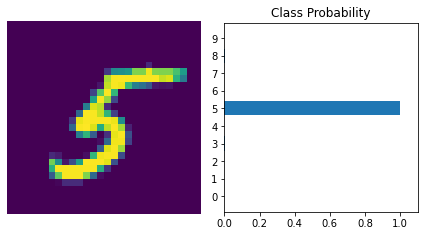

In [17]:
images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
view_classify(img.view(1, 28, 28), ps)